<a href="https://colab.research.google.com/github/nk-vj/Brain-Tumor-MRI-Classifier/blob/main/Brain_Tumour_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries**

In [ ]:
!unzip "/content/drive/MyDrive/Brain Tumour MRI.zip"

In [2]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 7.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,BatchNormalization,Dropout
from keras.models import Sequential
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

from keras.applications import VGG16
from keras.applications import ResNet50
from keras.applications import InceptionV3

from keras.utils import plot_model
import visualkeras

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# **Data Preproccesing**




In [4]:
path = "/content/Brain Tumour MRI"
os.listdir(path)

['Testing', 'Training']

In [5]:
os.listdir(path+'/Training')
os.listdir(path+'/Testing')

['pituitary_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor']

In [6]:
image_set = []
image_labels = []

labels = ['meningioma_tumor', 'glioma_tumor', 'no_tumor', 'pituitary_tumor']

img_size = 200

for i in os.listdir(path):
  path1 = os.path.join(path,i)
  for j in os.listdir(path1):
    path2 = os.path.join(path1,j)
    for k in os.listdir(path2):
      path3 = os.path.join(path2,k)
      img = cv2.imread(path3)
      if img is None:
        print(path3)
      img = cv2.resize(img, (img_size,img_size))
      img = np.array(img)
      image_set.append(img)
      image_labels.append(labels.index(j))

Splitting data into Training and Testing sets

In [7]:
image_set = np.array(image_set)
image_labels = np.array(image_labels)
image_set, image_labels = shuffle(image_set, image_labels, random_state = 30)
print(image_set.shape)
print(image_labels.shape)

(3264, 200, 200, 3)
(3264,)


In [8]:
train_set, test_set, train_labels, test_labels = train_test_split(image_set, image_labels, test_size = 0.1, random_state=7)
print(train_set.shape)
print(test_set.shape)
print(train_labels.shape)
print(test_labels.shape)

(2937, 200, 200, 3)
(327, 200, 200, 3)
(2937,)
(327,)


Some Visualisations - Sample images and Distrubution

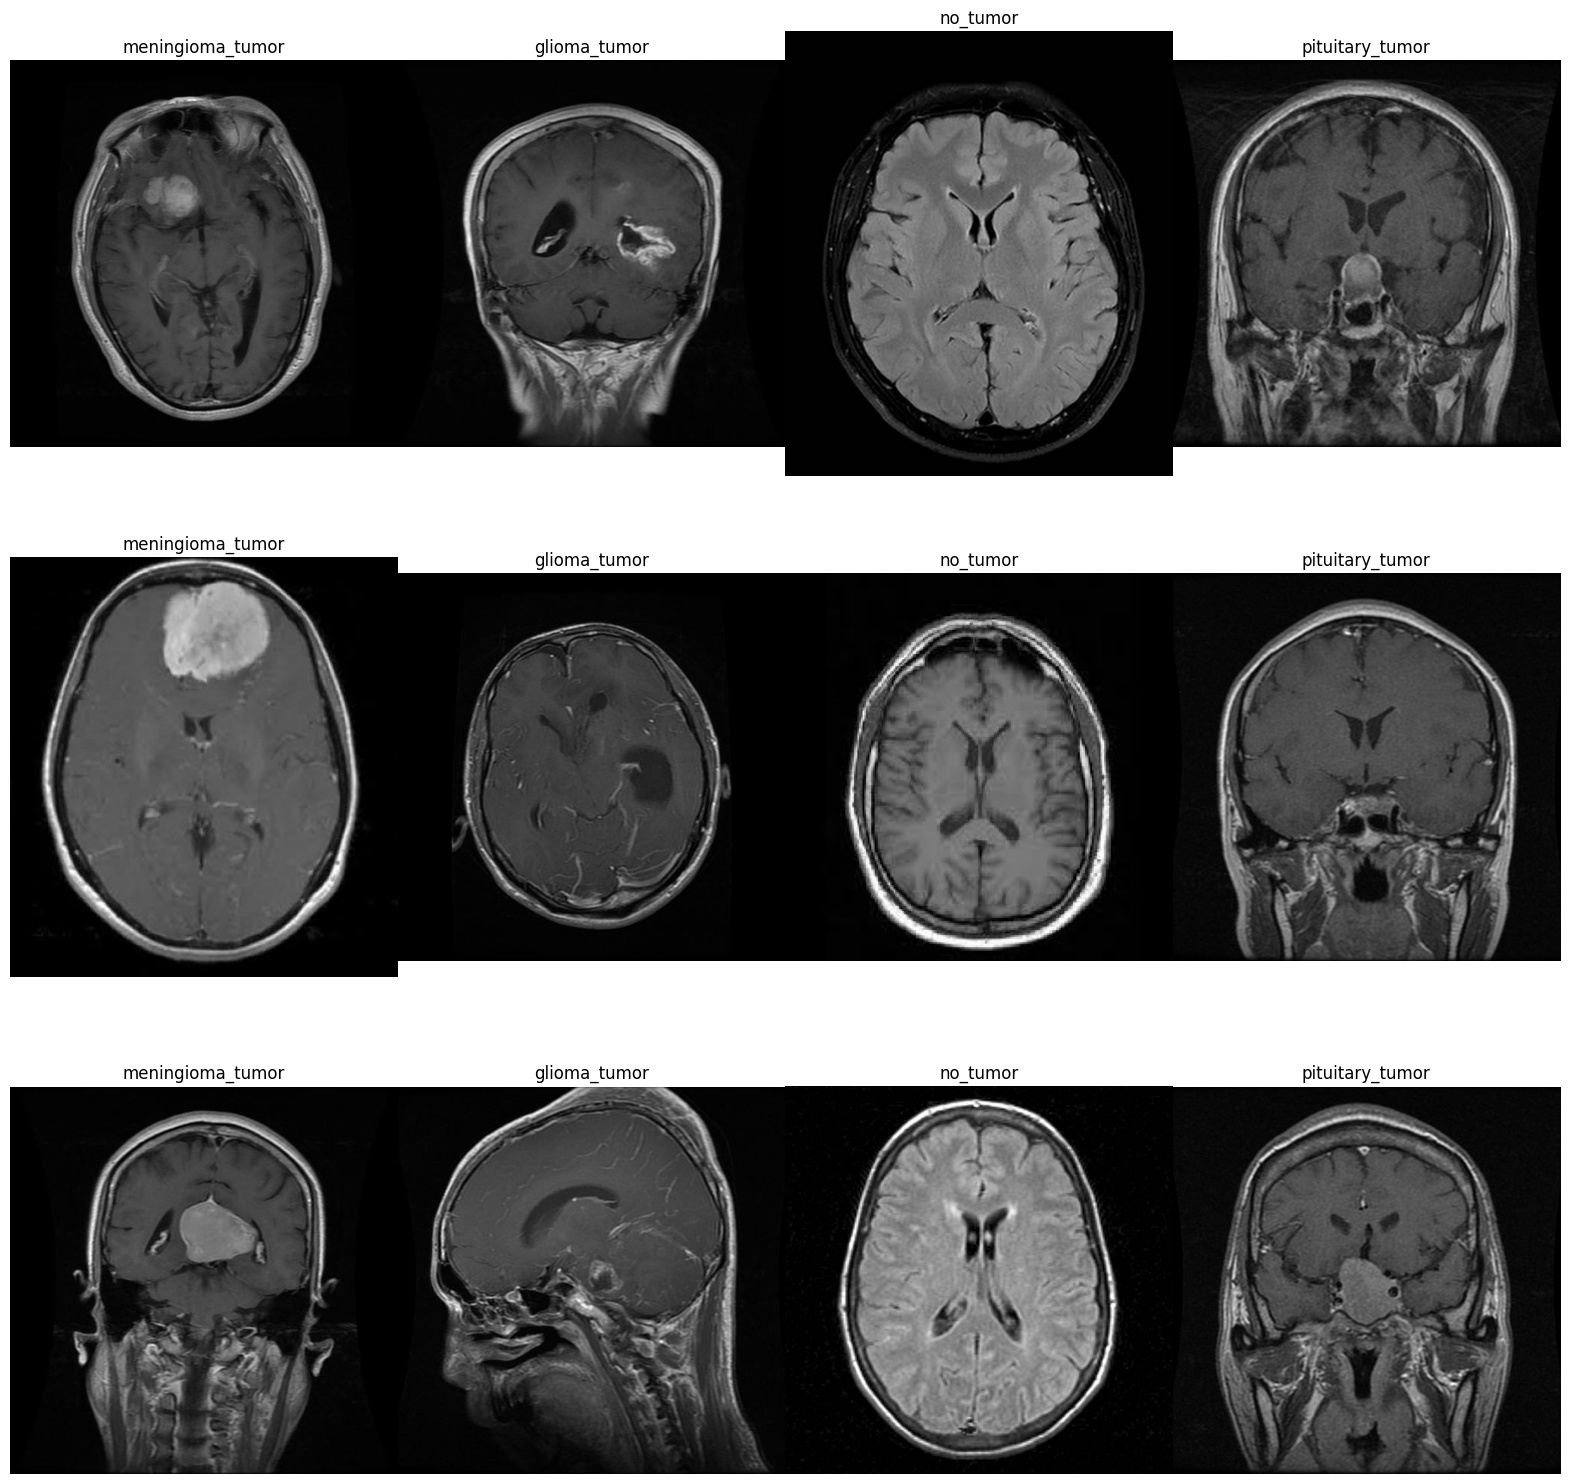

In [9]:
plt.figure(figsize=(20,20))
k=0
for i in range(0,3):
  for j in labels:
    file_name = os.listdir(path+'/'+'Training'+'/'+j)[i]
    img_arr = cv2.imread(path+'/'+'Training'+'/'+j+'/'+file_name)
    plt.subplot(3,4,k+1)
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.imshow(img_arr)
    plt.title(j)
    plt.axis('off')
    k+=1

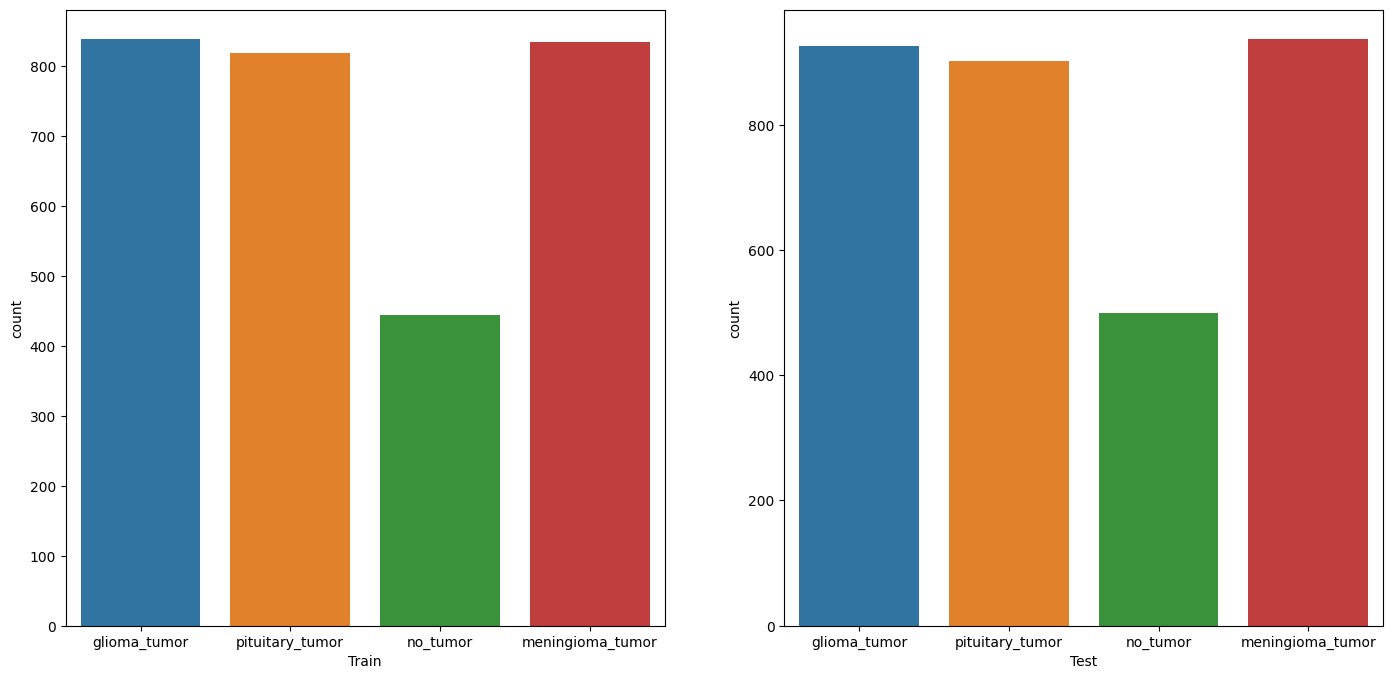

In [10]:
plt.figure(figsize = (17,8));
data = ['Train', 'Test']
class_list = []

for i,j in enumerate([train_labels.tolist(), test_labels.tolist()]):
    plt.subplot(1,2, i+1);
    for val in j:
      class_list.append(labels[val])
    sns.countplot(x = class_list);
    plt.xlabel(data[i])

Converting labelled data to One Hot encoded format

In [11]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)
print(train_labels.shape)
print(train_set.shape)

(2937, 4)
(2937, 200, 200, 3)


Data Augmentation

In [12]:
img_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        height_shift_range = 0.1,
        width_shift_range = 0.1,
        zoom_range=0.2,
        horizontal_flip=True
)

img_datagen.fit(train_set)
img_datagen.fit(test_set)

# **Creating Custom CNN Model and Training**

Defining callbacks

In [13]:
reduce_lr= ReduceLROnPlateau(monitor= "val_loss",
                         factor=0.1,
                         patience= 5,
                         verbose=1,
                         min_delta= 0.00001)

earlystop= EarlyStopping(monitor= "val_loss",
                         min_delta= 0,
                         patience= 5,
                         verbose=1,
                         restore_best_weights= True)

callbacks = [reduce_lr, earlystop]

CNN Architecture

In [14]:
model = Sequential()

model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',input_shape=(200,200,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1),padding='valid'))

model.add(Conv2D(filters=96,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1),padding='valid'))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1),padding='valid'))

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1),padding='valid'))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=["accuracy"])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 128)     3584      
                                                                 
 batch_normalization (Batch  (None, 198, 198, 128)     512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 197, 197, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 195, 195, 96)      110688    
                                                                 
 batch_normalization_1 (Bat  (None, 195, 195, 96)      384       
 chNormalization)                                                
                                                        

Model Architecture Diagram

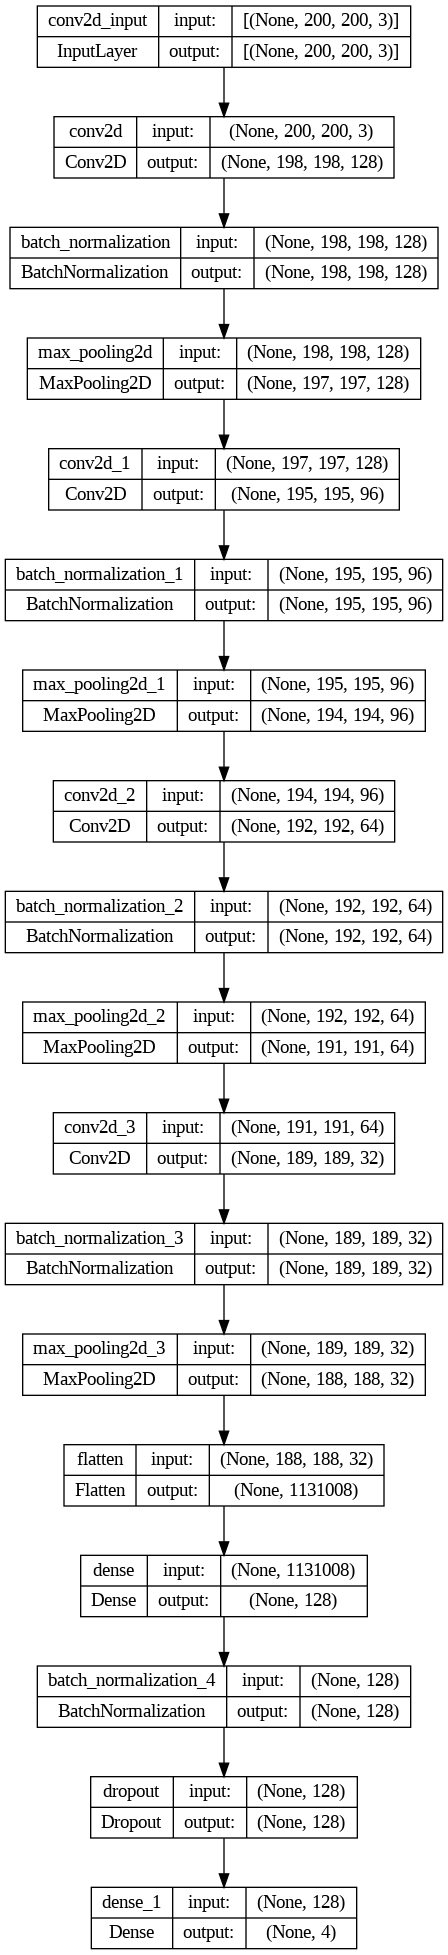

In [16]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Training the Model

In [17]:
history = model.fit(train_set, train_labels, batch_size=16, verbose=1,
                    epochs=10,
                    validation_split=0.1, callbacks = callbacks)

Epoch 1/10
166/166 [==============================] - 68s 297ms/step - loss: 1.0704 - accuracy: 0.6659 - val_loss: 1.1184 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 2/10
166/166 [==============================] - 44s 263ms/step - loss: 0.5284 - accuracy: 0.8089 - val_loss: 2.1871 - val_accuracy: 0.5204 - lr: 0.0010
Epoch 3/10
166/166 [==============================] - 45s 271ms/step - loss: 0.4643 - accuracy: 0.8271 - val_loss: 0.4848 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 4/10
166/166 [==============================] - 45s 270ms/step - loss: 0.3127 - accuracy: 0.8876 - val_loss: 0.4397 - val_accuracy: 0.8435 - lr: 0.0010
Epoch 5/10
166/166 [==============================] - 45s 271ms/step - loss: 0.1912 - accuracy: 0.9353 - val_loss: 0.3880 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 6/10
166/166 [==============================] - 45s 269ms/step - loss: 0.1458 - accuracy: 0.9531 - val_loss: 0.3821 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 7/10
166/166 [==============================] 

Plotting Training & Validation Accuracy/Loss over Epochs

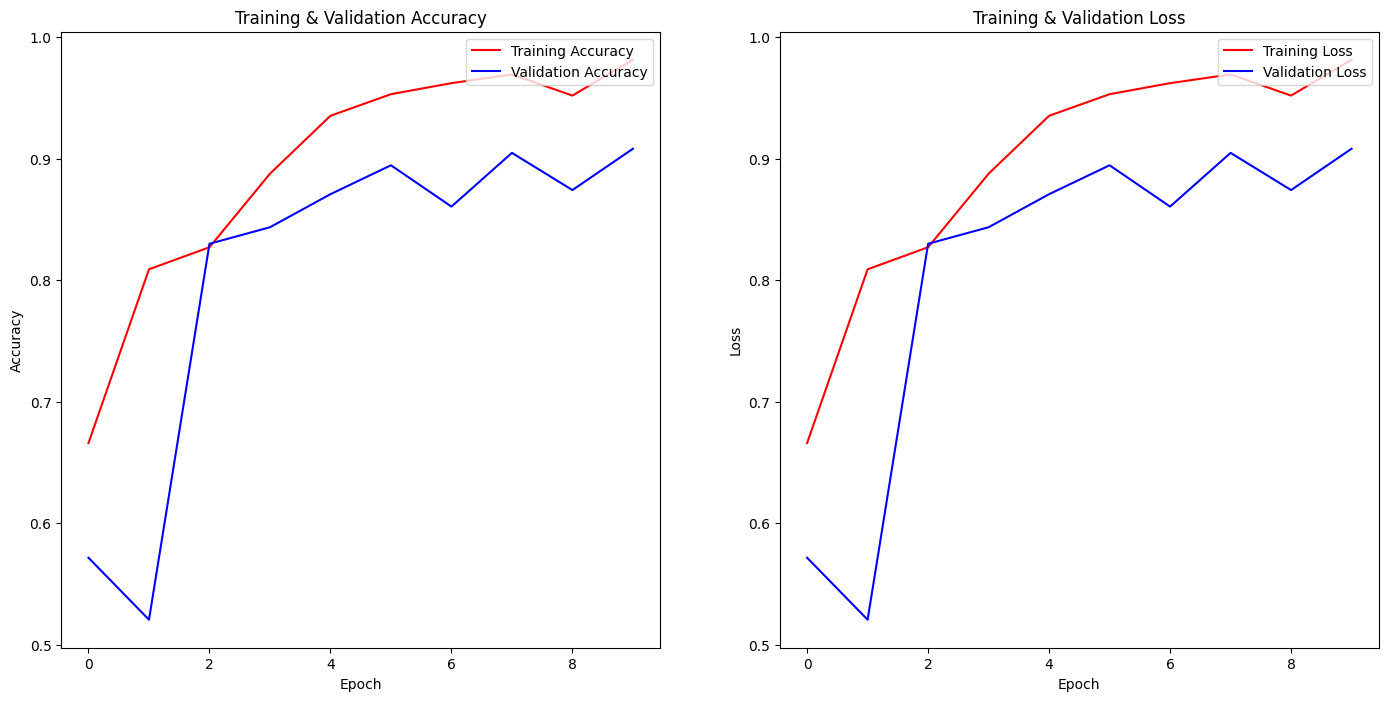

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17,8))
plt.subplot(1,2,1)
plt.plot(acc, label="Training Accuracy", color='r')
plt.plot(val_acc, label="Validation Accuracy", color='b')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.title('Training & Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(acc, label="Training Loss", color='r')
plt.plot(val_acc, label="Validation Loss", color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')

plt.show()

In [19]:
model.save('BTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Prediction**

In [20]:
pred_labels = model.predict(test_set)

11/11 [==============================] - 7s 254ms/step


In [21]:
pred_labels = np.argmax(pred_labels, axis=1)
pred_labels[:5]

array([0, 2, 3, 2, 1])

In [22]:
test_labels_new = np.argmax(test_labels, axis=1)
test_labels_new[:5]

array([0, 2, 3, 0, 1])

In [23]:
print(classification_report(test_labels_new, pred_labels))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       102
           1       0.97      0.84      0.90        87
           2       0.83      0.96      0.89        56
           3       0.99      0.96      0.98        82

    accuracy                           0.91       327
   macro avg       0.92      0.92      0.91       327
weighted avg       0.92      0.91      0.91       327



In [24]:
test_loss, test_acc = model.evaluate(test_set, test_labels)
print('Loss on testing data:', test_loss)
print('Accuracy on testing data', test_acc)

train_loss, train_acc = model.evaluate(train_set, train_labels)
print('Loss on training data:', train_loss)
print('Accuracy on training data', train_acc)

11/11 [==============================] - 1s 113ms/step - loss: 0.2996 - accuracy: 0.9144
Loss on testing data: 0.2996194362640381
Accuracy on testing data 0.9143730998039246
92/92 [==============================] - 15s 165ms/step - loss: 0.0589 - accuracy: 0.9854
Loss on training data: 0.058915965259075165
Accuracy on training data 0.9853591918945312


# **Transfer Learning**

VGG16

In [25]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size,img_size,3), pooling=max)

for layer in base_model.layers:
  layer.trainable = False

model1 = Sequential()
model1.add(base_model)

model1.add(Flatten())
model1.add(Dense(128,activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(4,activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [26]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2359424   
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                      

In [27]:
history1 = model1.fit(train_set, train_labels, batch_size=16, verbose=1,
                    epochs=10,
                    validation_split=0.1, callbacks = callbacks)

Epoch 1/10
166/166 [==============================] - 19s 86ms/step - loss: 0.5841 - accuracy: 0.8017 - val_loss: 0.3431 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 2/10
166/166 [==============================] - 11s 65ms/step - loss: 0.2001 - accuracy: 0.9327 - val_loss: 0.3546 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 3/10
166/166 [==============================] - 10s 63ms/step - loss: 0.1114 - accuracy: 0.9701 - val_loss: 0.3088 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 4/10
166/166 [==============================] - 11s 63ms/step - loss: 0.0912 - accuracy: 0.9773 - val_loss: 0.3112 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 5/10
166/166 [==============================] - 11s 65ms/step - loss: 0.0558 - accuracy: 0.9860 - val_loss: 0.2211 - val_accuracy: 0.9184 - lr: 0.0010
Epoch 6/10
166/166 [==============================] - 11s 65ms/step - loss: 0.0372 - accuracy: 0.9924 - val_loss: 0.3821 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 7/10
166/166 [==============================] - 11s 

In [28]:
test_loss, test_acc = model1.evaluate(test_set, test_labels)
print('Loss on testing data:', test_loss)
print('Accuracy on testing data', test_acc)

train_loss, train_acc = model1.evaluate(train_set, train_labels)
print('Loss on training data:', train_loss)
print('Accuracy on training data', train_acc)

11/11 [==============================] - 9s 288ms/step - loss: 0.2145 - accuracy: 0.9327
Loss on testing data: 0.21447032690048218
Accuracy on testing data 0.932721734046936
92/92 [==============================] - 15s 161ms/step - loss: 0.0373 - accuracy: 0.9894
Loss on training data: 0.037264250218868256
Accuracy on training data 0.9894450306892395


In [29]:
pred_labels1 = model1.predict(test_set)
pred_labels1 = np.argmax(pred_labels1, axis=1)
test_labels_new1 = np.argmax(test_labels, axis=1)

11/11 [==============================] - 1s 111ms/step


ResNet50

In [30]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size,img_size,3), pooling=max)

for layer in base_model.layers:
  layer.trainable = False

model2 = Sequential()
model2.add(base_model)

model2.add(Flatten())
model2.add(Dense(128,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(4,activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [31]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               12845184  
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                      

In [32]:
history2 = model2.fit(train_set, train_labels, batch_size=16, verbose=1,
                    epochs=10,
                    validation_split=0.1, callbacks = callbacks)

Epoch 1/10
166/166 [==============================] - 19s 77ms/step - loss: 0.5851 - accuracy: 0.7976 - val_loss: 0.2907 - val_accuracy: 0.9014 - lr: 0.0010
Epoch 2/10
166/166 [==============================] - 9s 56ms/step - loss: 0.1909 - accuracy: 0.9376 - val_loss: 0.2159 - val_accuracy: 0.9184 - lr: 0.0010
Epoch 3/10
166/166 [==============================] - 9s 54ms/step - loss: 0.0872 - accuracy: 0.9773 - val_loss: 0.2118 - val_accuracy: 0.9218 - lr: 0.0010
Epoch 4/10
166/166 [==============================] - 9s 52ms/step - loss: 0.0685 - accuracy: 0.9807 - val_loss: 0.2650 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 5/10
166/166 [==============================] - 9s 56ms/step - loss: 0.0359 - accuracy: 0.9909 - val_loss: 0.1781 - val_accuracy: 0.9456 - lr: 0.0010
Epoch 6/10
166/166 [==============================] - 9s 52ms/step - loss: 0.0327 - accuracy: 0.9928 - val_loss: 0.2058 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 7/10
166/166 [==============================] - 8s 50ms/s

In [33]:
test_loss, test_acc = model2.evaluate(test_set, test_labels)
print('Loss on testing data:', test_loss)
print('Accuracy on testing data', test_acc)

train_loss, train_acc = model2.evaluate(train_set, train_labels)
print('Loss on training data:', train_loss)
print('Accuracy on training data', train_acc)

11/11 [==============================] - 4s 177ms/step - loss: 0.2862 - accuracy: 0.9235
Loss on testing data: 0.2862028181552887
Accuracy on testing data 0.9235473871231079
92/92 [==============================] - 9s 98ms/step - loss: 0.0407 - accuracy: 0.9888
Loss on training data: 0.040663912892341614
Accuracy on training data 0.9887640476226807


In [34]:
pred_labels2 = model2.predict(test_set)
pred_labels2 = np.argmax(pred_labels2, axis=1)
test_labels_new2 = np.argmax(test_labels, axis=1)

11/11 [==============================] - 2s 79ms/step


InceptionV3

In [35]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size,img_size,3), pooling=max)

for layer in base_model.layers:
  layer.trainable = False

model3 = Sequential()
model3.add(base_model)

model3.add(Flatten())
model3.add(Dense(128,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(4,activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [36]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               4194432   
                                                                 
 batch_normalization_101 (B  (None, 128)               512       
 atchNormalization)                                              
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                      

In [37]:
history3 = model3.fit(train_set, train_labels, batch_size=16, verbose=1,
                    epochs=10,
                    validation_split=0.1, callbacks = callbacks)

Epoch 1/10
166/166 [==============================] - 18s 65ms/step - loss: 0.8868 - accuracy: 0.6659 - val_loss: 0.9830 - val_accuracy: 0.6327 - lr: 0.0010
Epoch 2/10
166/166 [==============================] - 6s 35ms/step - loss: 0.5655 - accuracy: 0.7885 - val_loss: 0.5270 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 3/10
166/166 [==============================] - 6s 34ms/step - loss: 0.4728 - accuracy: 0.8335 - val_loss: 0.7325 - val_accuracy: 0.7415 - lr: 0.0010
Epoch 4/10
166/166 [==============================] - 5s 33ms/step - loss: 0.4118 - accuracy: 0.8589 - val_loss: 0.6431 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 5/10
166/166 [==============================] - 6s 35ms/step - loss: 0.3494 - accuracy: 0.8804 - val_loss: 0.8309 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 6/10
166/166 [==============================] - 5s 32ms/step - loss: 0.2744 - accuracy: 0.9122 - val_loss: 0.5357 - val_accuracy: 0.7789 - lr: 0.0010
Epoch 7/10
165/166 [============================>.] - ETA: 0s -

In [38]:
test_loss, test_acc = model3.evaluate(test_set, test_labels)
print('Loss on testing data:', test_loss)
print('Accuracy on testing data', test_acc)

train_loss, train_acc = model3.evaluate(train_set, train_labels)
print('Loss on training data:', train_loss)
print('Accuracy on training data', train_acc)

11/11 [==============================] - 5s 215ms/step - loss: 0.5462 - accuracy: 0.7951
Loss on testing data: 0.5462238788604736
Accuracy on testing data 0.7951070070266724
92/92 [==============================] - 6s 70ms/step - loss: 0.4318 - accuracy: 0.8635
Loss on training data: 0.43182802200317383
Accuracy on training data 0.8634661436080933


In [39]:
pred_labels3 = model3.predict(test_set)
pred_labels3 = np.argmax(pred_labels3, axis=1)

11/11 [==============================] - 2s 45ms/step


# **Models Comparison**

Confusion Matrices

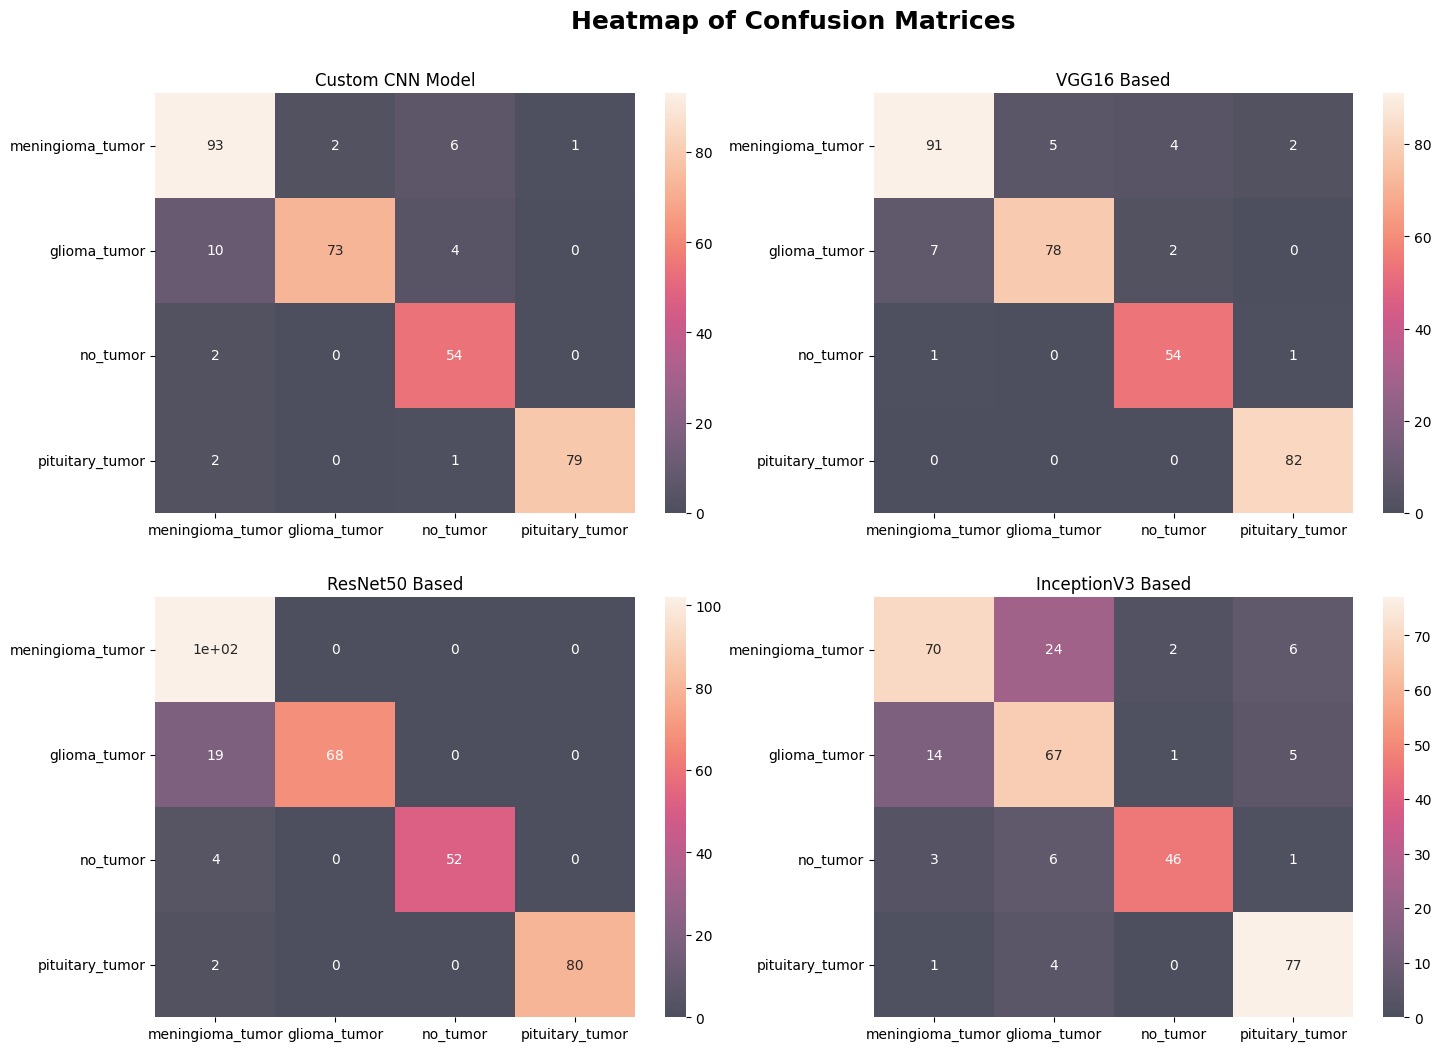

In [47]:
plt.figure(figsize=(17,12))
plt.subplot(2,2,1)
plt.title('Custom CNN Model')
sns.heatmap(confusion_matrix(test_labels_new, pred_labels), xticklabels=labels, yticklabels=labels,annot=True, alpha=0.7)

plt.subplot(2,2,2)
plt.title('VGG16 Based')
sns.heatmap(confusion_matrix(test_labels_new, pred_labels1), xticklabels=labels, yticklabels=labels,annot=True, alpha=0.7)

plt.subplot(2,2,3)
plt.title('ResNet50 Based')
sns.heatmap(confusion_matrix(test_labels_new, pred_labels2), xticklabels=labels, yticklabels=labels,annot=True, alpha=0.7)

plt.subplot(2,2,4)
plt.title('InceptionV3 Based')
sns.heatmap(confusion_matrix(test_labels_new, pred_labels3), xticklabels=labels, yticklabels=labels,annot=True, alpha=0.7)

plt.suptitle('Heatmap of Confusion Matrices', fontsize=18, fontweight='bold', y=0.95)

plt.show()

Loss Curves


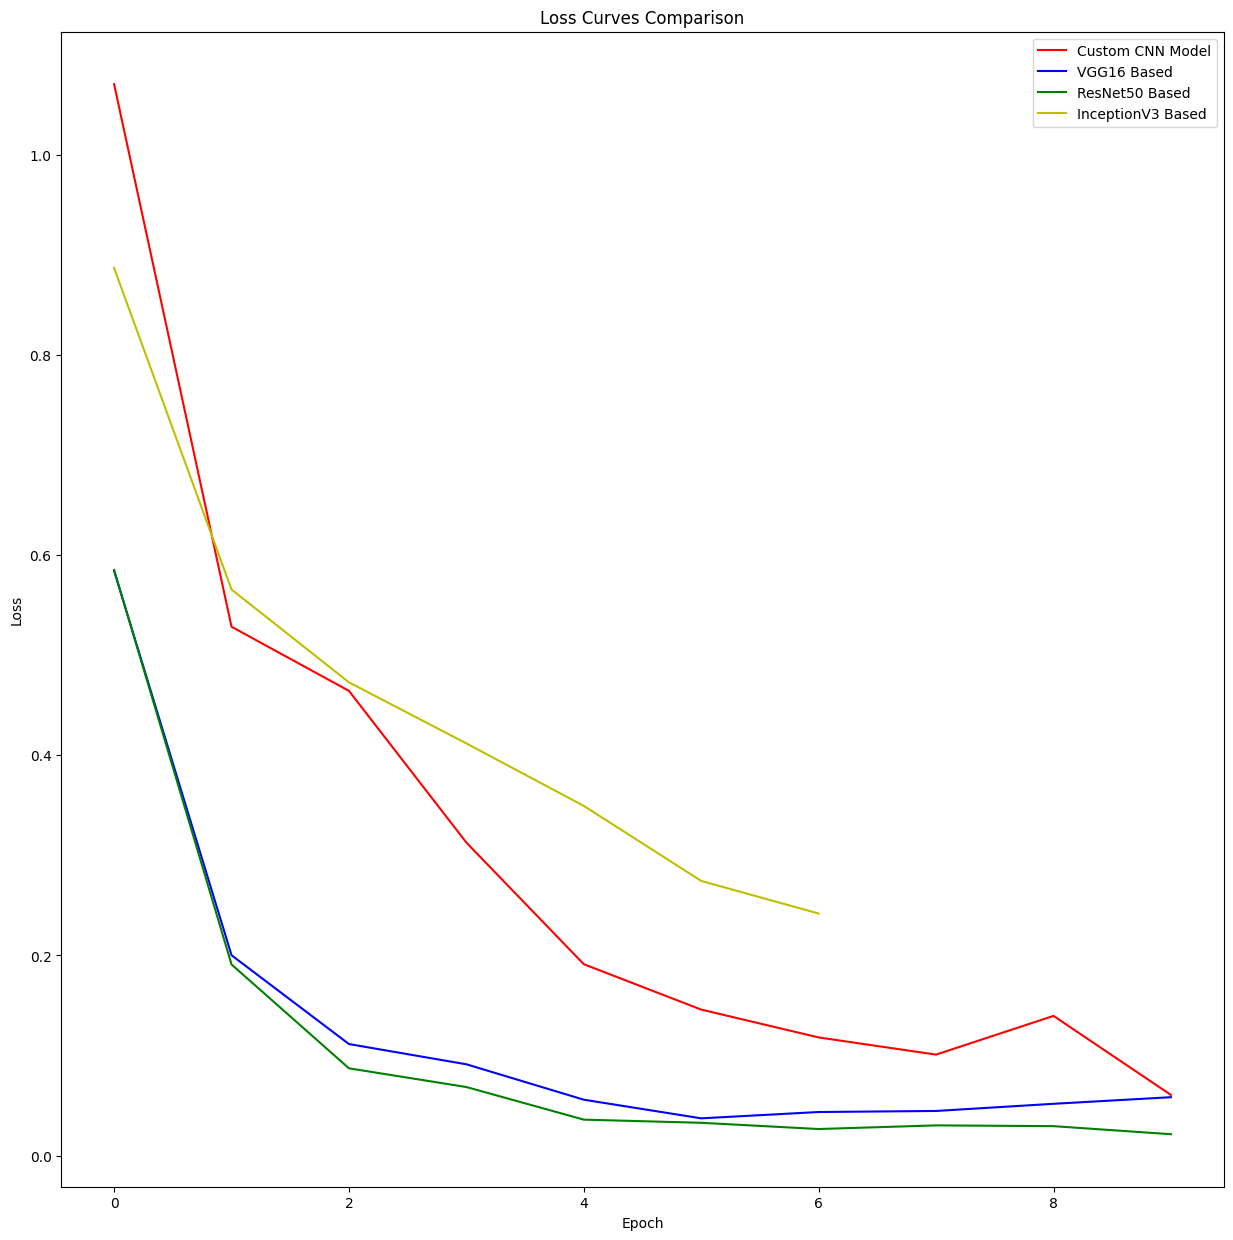

In [48]:
loss = history.history['loss']
loss1 = history1.history['loss']
loss2 = history2.history['loss']
loss3 = history3.history['loss']

plt.figure(figsize=(15,15))
plt.plot(loss, label = "Custom CNN Model", color='r')
plt.plot(loss1, label = "VGG16 Based", color='b')
plt.plot(loss2, label = "ResNet50 Based", color='g')
plt.plot(loss3, label = "InceptionV3 Based", color='y')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves Comparison')

plt.show()